In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing libraries

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
from sklearn.metrics import classification_report, confusion_matrix
 
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
 
import cv2
 
import warnings
warnings.filterwarnings('ignore')

# Reading data

In [24]:
# datasets
labels = pd.read_csv("../input/dog-breed-identification-mlbootcamp/labels.csv")
sample = pd.read_csv('../input/dog-breed-identification-mlbootcamp/sample_submission.csv')
 
# folders paths
train_path = "../input/dog-breed-identification-mlbootcamp/train"
test_path = "../input/dog-breed-identification-mlbootcamp/test"
print('Done!')

Done!


In [25]:

labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [26]:
def to_jpg(id):
    return id+".jpg"
 

labels['id'] = labels['id'].apply(to_jpg)
sample['id'] = sample['id'].apply(to_jpg)
print('Done!')

Done!


# Data agumentation and pre-processing

In [27]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(
                  rescale=1./255.,
                  horizontal_flip = True,
                  validation_split=0.2 # training: 80% data, validation: 20% data
                 )
 
train_generator = gen.flow_from_dataframe(
    labels, # dataframe
    directory = train_path, # images data path / folder in which images are there
    x_col = 'id',
    y_col = 'breed',
    subset="training",
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)
 
 
validation_generator = gen.flow_from_dataframe(
    labels, # dataframe
    directory = train_path, # images data path / folder in which images are there
    x_col = 'id',
    y_col = 'breed',
    subset="validation",
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [28]:
x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 32: is the batch size

(32, 331, 331, 3)

# Visualizing dogs image

Done!


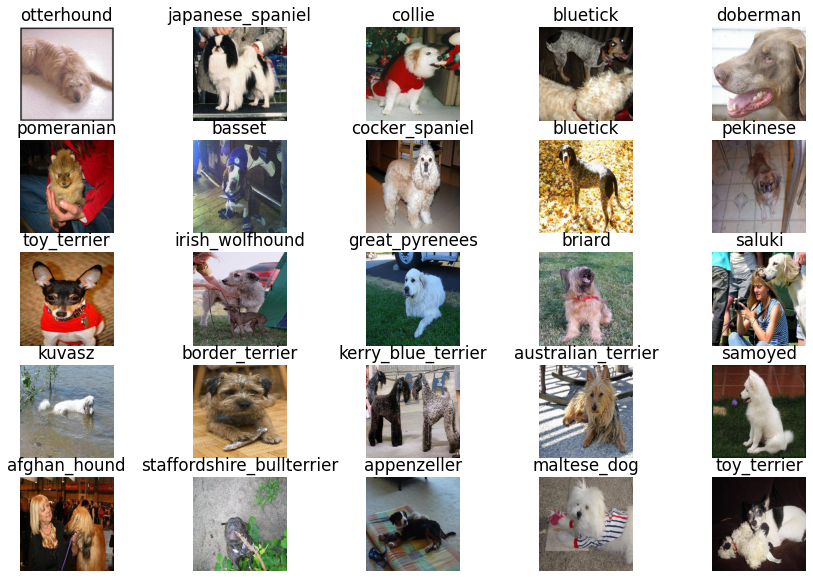

In [29]:
a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list
 
def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
plot_images(x,y)
print("Done!")

# Model

In [30]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(331,331,3)
                     )
 
base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
 
model = tf.keras.Sequential([
        base_model,  
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(120, activation='softmax')
    ])

print('Done!')

Done!


In [31]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )

print('Done!')

Done!


In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 9, 9, 1536)        54336736  
_________________________________________________________________
batch_normalization_407 (Bat (None, 9, 9, 1536)        10752     
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               786944    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [33]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)
# early stopping call back
print('Done!')

Done!


In [34]:
batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
 
# fit model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=[early]
                   )

print('Done!')

Epoch 1/25
255/255 [==============================] - 144s 526ms/step - loss: 1.7087 - accuracy: 0.6336 - val_loss: 0.3888 - val_accuracy: 0.8993
Epoch 2/25
255/255 [==============================] - 132s 518ms/step - loss: 0.5528 - accuracy: 0.8620 - val_loss: 0.3917 - val_accuracy: 0.8894
Epoch 3/25
255/255 [==============================] - 131s 515ms/step - loss: 0.4622 - accuracy: 0.8750 - val_loss: 0.3615 - val_accuracy: 0.9023
Epoch 4/25
255/255 [==============================] - 132s 516ms/step - loss: 0.4273 - accuracy: 0.8853 - val_loss: 0.3622 - val_accuracy: 0.9067
Epoch 5/25
255/255 [==============================] - 132s 518ms/step - loss: 0.4043 - accuracy: 0.8896 - val_loss: 0.3685 - val_accuracy: 0.9038
Epoch 6/25
255/255 [==============================] - 132s 515ms/step - loss: 0.3646 - accuracy: 0.9013 - val_loss: 0.3963 - val_accuracy: 0.8983
Epoch 7/25
255/255 [==============================] - 132s 518ms/step - loss: 0.3488 - accuracy: 0.8992 - val_loss: 0.3842 -

# Saving model

In [44]:
model.save("Model.h5")

# Visualizing model with different parameters

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy:0.9199607372283936\nValidation Accuracy: 0.9082341194152832')

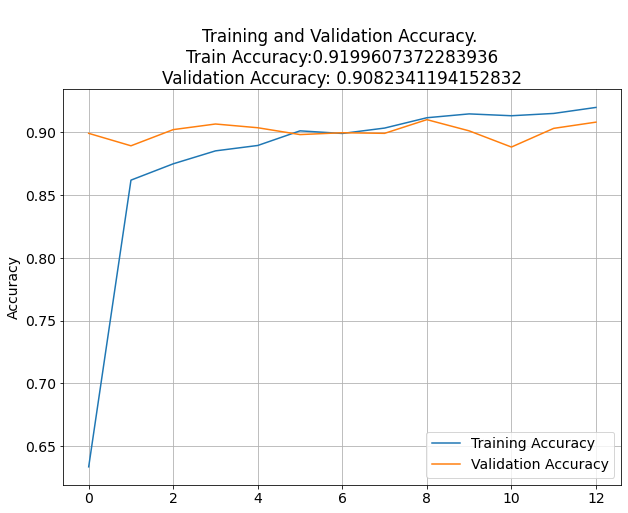

In [45]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:{str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

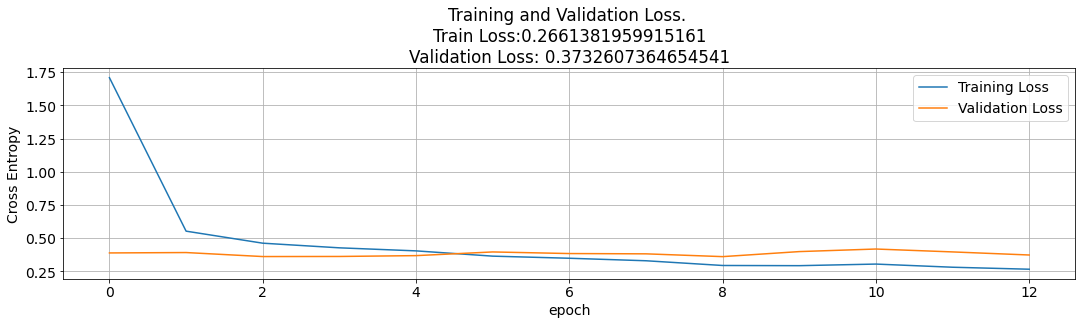

In [46]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

# Printing model accuracy and loss

In [47]:
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
 
print("Loss: ",accuracy_score[0])

64/64 [==============================] - 26s 407ms/step - loss: 0.3545 - accuracy: 0.9041
[0.3544732332229614, 0.9041095972061157]
Accuracy: 90.4110%
Loss:  0.3544732332229614


# Testing with an example

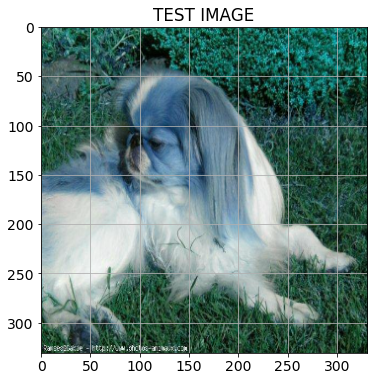

In [48]:
test_img_path = test_path+"/000621fb3cbb32d8935728e48679680e.jpg"
 
img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (331, 331)).reshape(-1, 331, 331, 3)/255
 
plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])

In [49]:
predictions = []
 
for image in sample.id:
    img = tf.keras.preprocessing.image.load_img(test_path +'/'+ image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (331, 331))
    img = tf.reshape(img, (-1, 331, 331, 3))
    prediction = model.predict(img/255)
    predictions.append(np.argmax(prediction))
#     print(prediction)

my_submission = pd.DataFrame({'image_id': sample.id, 'label':  predictions})
my_submission.to_csv('submission.csv', index=False)
 
# Submission file ouput
print("Submission File: \n---------------\n")
print(my_submission.head()) # Displaying first five predicted output

Submission File: 
---------------

                               image_id  label
0  000621fb3cbb32d8935728e48679680e.jpg     61
1  00102ee9d8eb90812350685311fe5890.jpg     94
2  0012a730dfa437f5f3613fb75efcd4ce.jpg     40
3  001510bc8570bbeee98c8d80c8a95ec1.jpg     88
4  001a5f3114548acdefa3d4da05474c2e.jpg     70


In [56]:
print(len(prediction[0]))

120


In [67]:
sample.loc[1]
# = prediction[0]

id                             00102ee9d8eb90812350685311fe5890.jpg
affenpinscher                                              0.008333
afghan_hound                                               0.008333
african_hunting_dog                                        0.008333
airedale                                                   0.008333
                                               ...                 
welsh_springer_spaniel                                     0.008333
west_highland_white_terrier                                0.008333
whippet                                                    0.008333
wire-haired_fox_terrier                                    0.008333
yorkshire_terrier                                          0.008333
Name: 1, Length: 121, dtype: object